In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Dataset

In [1]:
!pip install kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.1 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=fce4f92828c2e56d554ec7df51f38ff2ec39bdb2cf8d4d1d7f3b86d9250c8e93
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import os

os.environ['KAGGLE_USERNAME'] = 'kasund98'
os.environ['KAGGLE_KEY'] = '8454cbbc77fa2611059f9c2e27f9447b'


In [8]:
import kaggle

# Define the dataset slug
dataset_slug = 'arjuntejaswi/plant-village'

# Use the Kaggle API to download the dataset
kaggle.api.dataset_download_files(dataset_slug, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village


In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [10]:
import shutil

# Define the path to the directory containing the folders
output_dir = '/kaggle/working/PlantVillage'

# Define the names of the folders you want to delete
folders_to_delete = ['Potato___healthy', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Potato___Early_blight', 'Pepper__bell___healthy']

# Iterate through each folder and delete it
for folder_name in folders_to_delete:
    folder_path = os.path.join(output_dir, folder_name)
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_name}' deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_name}' not found.")
    except Exception as e:
        print(f"Error occurred while deleting folder '{folder_name}': {e}")


Folder 'Potato___healthy' deleted successfully.
Folder 'Potato___Late_blight' deleted successfully.
Folder 'Pepper__bell___Bacterial_spot' deleted successfully.
Folder 'Potato___Early_blight' deleted successfully.
Folder 'Pepper__bell___healthy' deleted successfully.


# Tomato Disease Classification

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [12]:
import tensorflow as tf
from tensorflow import keras


In [13]:


dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/working/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [14]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


In [16]:
%matplotlib inline


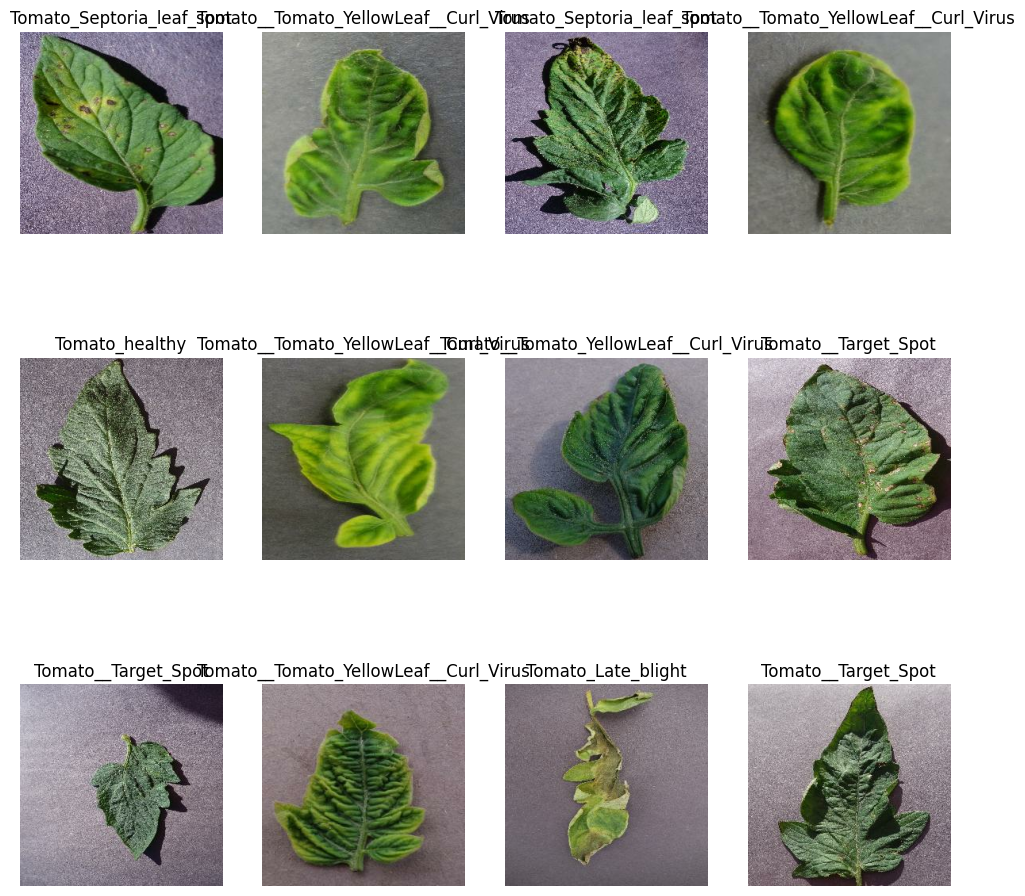

In [17]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Split dataset

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

400

**Cache, Shuffle, and Prefetch the Dataset**

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2024-04-19 16:45:58.772907: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 5.22285, expected 4.50617
2024-04-19 16:45:58.772985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 19: 4.83523, expected 4.11855
2024-04-19 16:45:58.772997: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 6.14347, expected 5.42679
2024-04-19 16:45:58.773006: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 5.72417, expected 5.00749
2024-04-19 16:45:58.773015: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 6.00776, expected 5.29109
2024-04-19 16:45:58.773026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 5.39609, expected 4.67941
2024-04-19 16:45:58.773036: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 5.14673, expected 4.43005
2024-04-19 16:45:58.773045: E external/local_xla/

  1/400 ━━━━━━━━━━━━━━━━━━━━ 2:14:45 20s/step - accuracy: 0.0000e+00 - loss: 2.3246

I0000 00:00:1713545166.413754     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713545166.437494     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


400/400 ━━━━━━━━━━━━━━━━━━━━ 176s 391ms/step - accuracy: 0.2907 - loss: 1.9331 - val_accuracy: 0.5006 - val_loss: 1.3500
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 150s 375ms/step - accuracy: 0.5618 - loss: 1.2589 - val_accuracy: 0.6031 - val_loss: 1.1720
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 150s 374ms/step - accuracy: 0.6449 - loss: 1.0217 - val_accuracy: 0.6463 - val_loss: 0.9525
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 146s 364ms/step - accuracy: 0.6863 - loss: 0.9076 - val_accuracy: 0.7069 - val_loss: 0.8413
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 366ms/step - accuracy: 0.7061 - loss: 0.8348 - val_accuracy: 0.7344 - val_loss: 0.7316
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 368ms/step - accuracy: 0.7459 - loss: 0.7177 - val_accuracy: 0.7731 - val_loss: 0.6326
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 147s 367ms/step - accuracy: 0.7606 - loss: 0.6909 - val_accuracy: 0.7919 - val_loss: 0.5642
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 148s 370ms/step - accuracy: 0.7913 - loss: 0.59

In [32]:
import gc

In [33]:
gc.collect()

482

In [1]:
scores = model.evaluate(test_ds)

NameError: name 'model' is not defined

In [ ]:
scores

In [2]:
history

scores = model.evaluate(test_ds)
history


In [3]:
history.params

NameError: name 'history' is not defined

In [4]:
history.history.keys()

NameError: name 'history' is not defined

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:

model.export('/kaggle/working/models')

Saved artifact at '/kaggle/working/models'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133826286328240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286329648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286332464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286330704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286322256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286332112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286334576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286337744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286338816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133826286338288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1338

In [33]:
model.save('tomato.h5')

In [34]:
import shutil

# Define the path to the models folder
models_folder_path = '/kaggle/working/models'

# Zip the folder
shutil.make_archive('/kaggle/working/models', 'zip', models_folder_path)


'/kaggle/working/models.zip'